## Описание данных

- **'Churn'** — факт оттока в текущем месяце;
- Данные пользователя за предыдущий до проверки факта оттока месяц:
    - **'gender'** — пол
    - **'Near_Location'** — проживание или работа в районе, где находится фитнес-центр
    - **'Partner'** — сотрудник компании-партнёра клуба
    - **Promo_friends** — факт первоначальной записи в рамках акции «приведи друга»
    - **'Phone'** — наличие контактного телефона
    - **'Age'** — возраст
    - **'Lifetime'** — время с момента первого обращения в фитнес-центр (в месяцах)
- Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
    - **'Contract_period'** — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
    - **'Month_to_end_contract'** — срок до окончания текущего действующего абонемента (в месяцах)
    - **'Group_visits'** — факт посещения групповых занятий
    - **'Avg_class_frequency_total'** — средняя частота посещений в неделю за все время с начала действия абонемента
    - **'Avg_class_frequency_current_month'** — средняя частота посещений в неделю за предыдущий месяц
    - **'Avg_additional_charges_total'** — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
    
## План анализа
1. Загрузить датасет и изучить общую информацию
2. Провести исследовательский анализ данных
3. Построить модель прогнозирования оттока пользователей
4. Провести кластеризацию пользователей
5. Общие выводы и рекомендации

<a id="upload"></a>
# 1. Загрузить датасет и изучить общую информацию

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# прочитаем датасет
gym = pd.read_csv('/datasets/gym_churn.csv')
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
gym.shape

(4000, 14)

In [4]:
# изучим общую информацию
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [6]:
# приведем названия столбов к однмоу формату
gym.columns = gym.columns.str.lower()
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Вывод

- Датасет **`gym`** состоит из 14 столбцов и 4000 строк.
- Данные сохранены в числовых форматах int64 float64, категориальных переменных нет.
- Столбцы приведены к одному виду методом str.lower().
- Для дальнейшего анализа необходимо провести исследовательский анализ данных и выделить показатель churn как зависимую переменную.

<a id="eda"></a>
# 2. Провести исследовательский анализ данных

In [7]:
# проверим дубликаты
gym.duplicated().sum()

0

In [8]:
# проверим пропуски
gym.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [10]:
# транспонируем таблицу для удобной работы с ней и изучим средние значения и стандартные отклонения
gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [10]:
# выделим средние значения по группам churn
gym.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


- стандартные отклонения в большинстве случаев приближаются к среднему в исследуемом датасете;
- при группировке данных по столбцу **churn** заметна значительная разница средних при churn=0 и churn=1 в столбцах **promo_friends, contract_period, group_visits, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_current_month**

In [11]:
# разделим датасет по столбцу churn
churn_0 = gym.query('churn == 0')
churn_1 = gym.query('churn == 1')

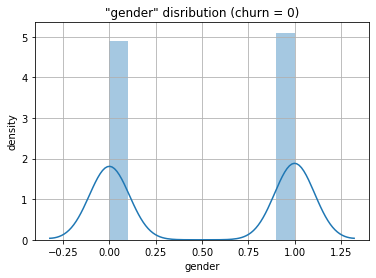

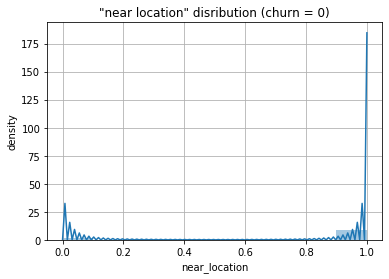

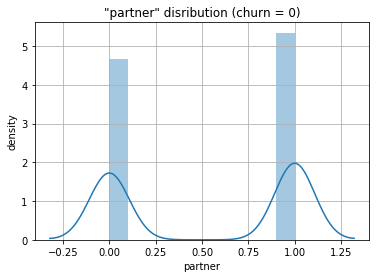

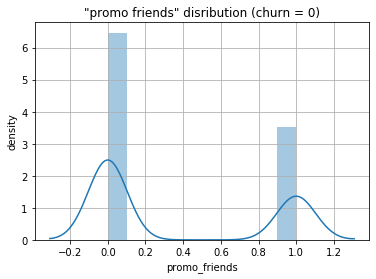

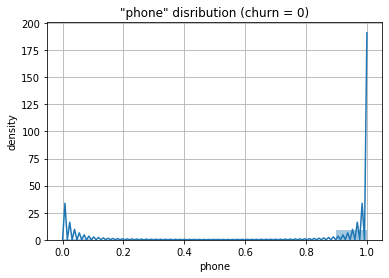

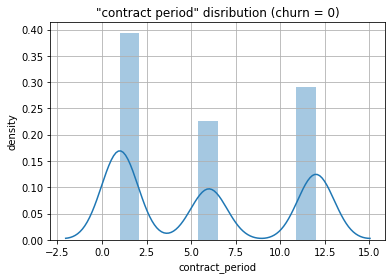

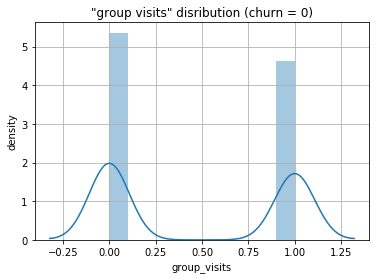

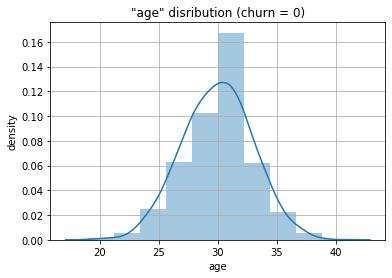

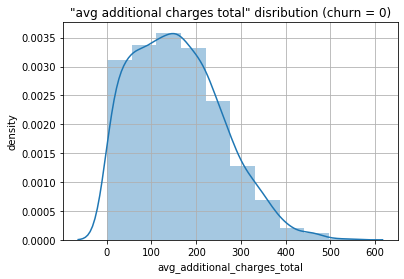

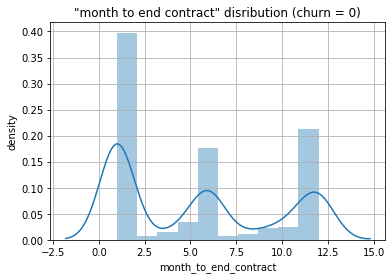

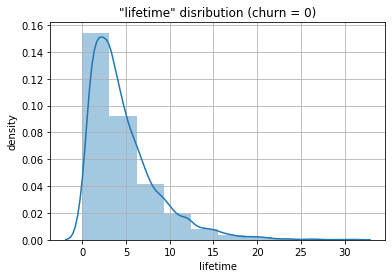

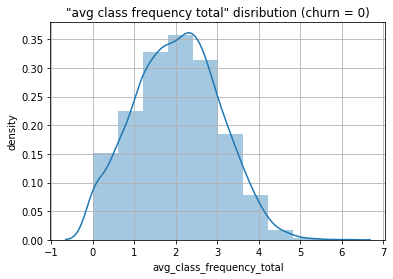

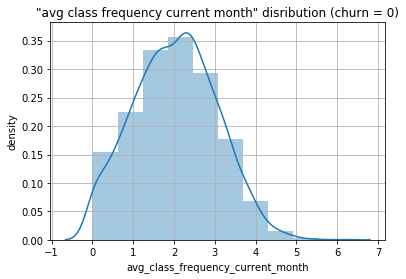

In [12]:
# построим гистограммы распределения признаков для churn = 0
for column in churn_0.drop('churn', axis=1).columns:
    sns.distplot(churn_0[column], bins = 10)
    plt.grid(True)
    plt.ylabel('density')
    plt.title('"{}" disribution (churn = 0)'.format(column.replace('_', ' ')))
    plt.show()

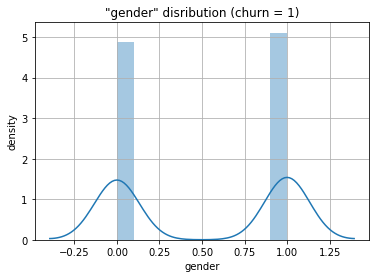

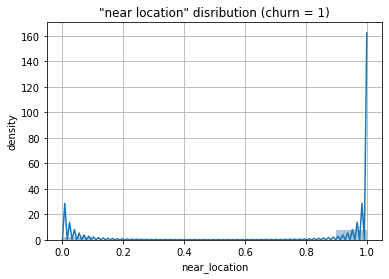

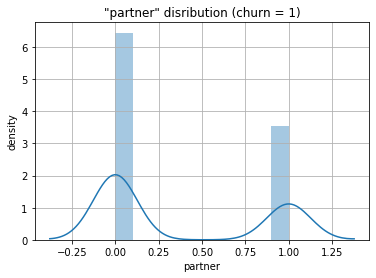

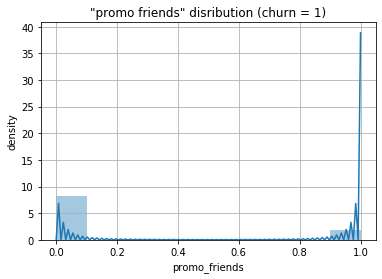

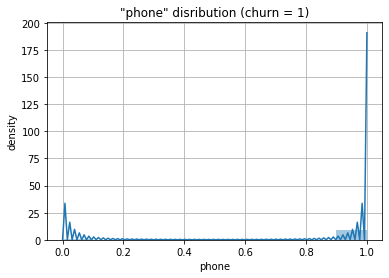

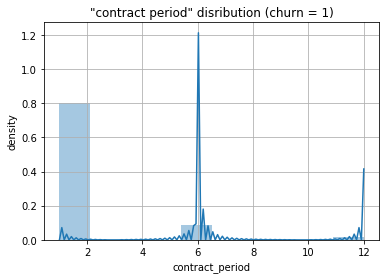

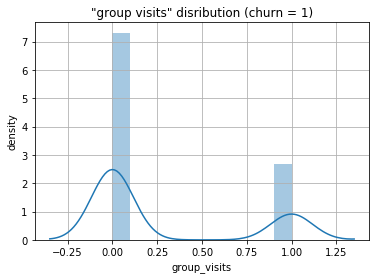

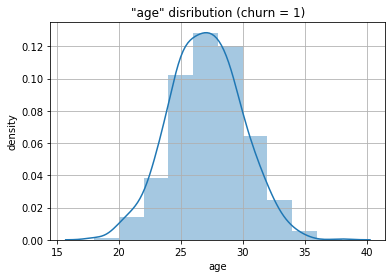

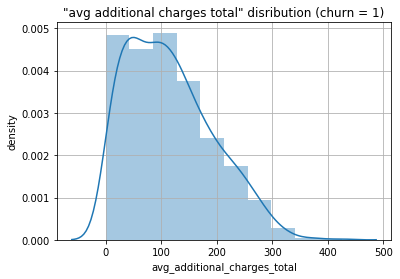

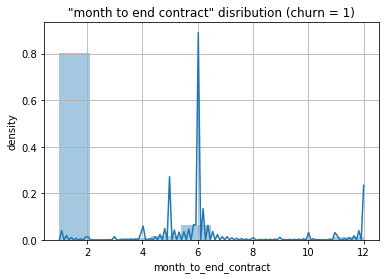

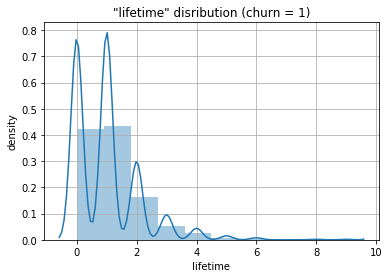

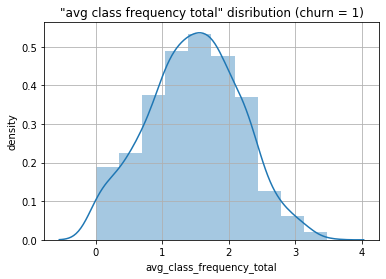

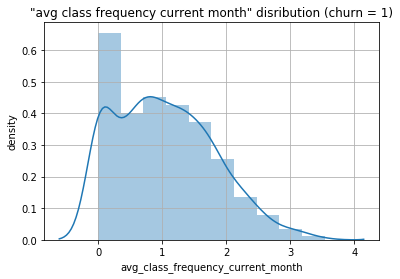

In [13]:
# построим гистограммы распределения признаков для churn = 1
for column in churn_1.drop('churn', axis=1).columns:
    sns.distplot(churn_1[column], bins = 10)
    plt.grid(True)
    plt.ylabel('density')
    plt.title('"{}" disribution (churn = 1)'.format(column.replace('_', ' ')))
    plt.show()

- взяты распределения отдельных признаков без целевой переменной (всего 13 для каждого датасета)
- если говорить не о бинарных признаках, то распределения **churn_0** и **churn_1** значительно отличаются в столбцах *avg_additional_charges_total, avg_class_frequency_current_month, avg_class_frequency_total, lifetime, month_to_end_contract*

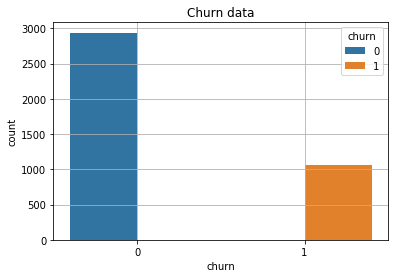

In [14]:
# визуализируем показатель churn
sns.countplot(x=gym.churn, hue='churn', data=gym)
plt.grid(True)
plt.title('Churn data')
plt.show()

In [15]:
gym.churn.mean()

0.26525

- Около 75% клиентов остаются с «Культуристом-датасаентистом»

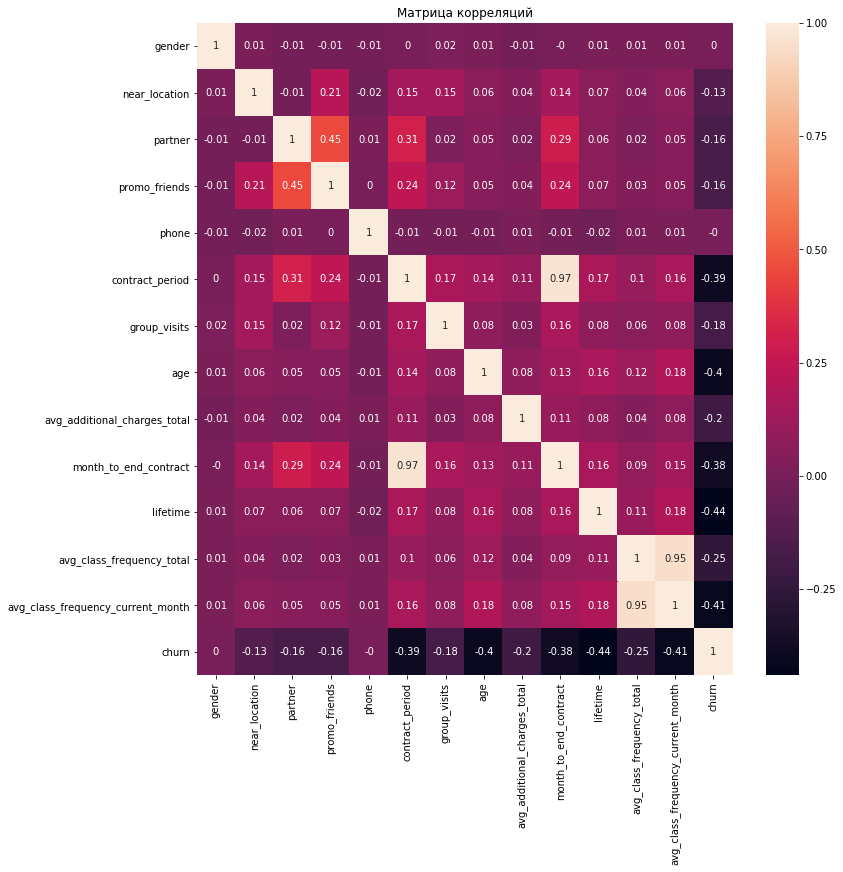

In [16]:
# корреляция данных общего датасета gym
corr = gym.corr().round(2)

plt.figure(figsize=(12, 12))
ax = sns.heatmap(corr, annot=True)
plt.title('Матрица корреляций')
plt.show()

- Среди всех признаков сильно коррелируют друг с другом **month_to_end_contract** и **contract_period** (0.97), **'avg_class_frequency_current_month'** и **'avg_class_frequency_total'** (0.95).
- Сильной пложительной корреляции показателя churn с другими признаками не выявлено. Большинство корреляций - отрицательные, например, корреляция **lifetime-churn** равна -0.44.

### Вывод

- На втором этапе проведен исследовательский анализ данных датасета gym:
- Проверены пропуски и дубликаты,
- Изучены показатели среднего значения и стандартного отклонения всего датасета:
    - стандартные отклонения в большинстве случаев приближаются к среднему в исследуемом датасете;
- При группировке данных по столбцу **churn** заметна значительная разница средних при churn=0 и churn=1 в столбцах **promo_friends, contract_period, group_visits, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_current_month**
- Изучены столбчатые гистограммы распределения 13 признаков:
    - взяты распределения отдельных признаков без целевой переменной (всего 13 для каждого датасета)
    - если говорить не о бинарных признаках, то распределения **churn_0** и **churn_1** визуально значительно отличаются в столбцах *avg_additional_charges_total, avg_class_frequency_current_month, avg_class_frequency_total, lifetime, month_to_end_contract*,
- Построена тепловая карта корреляций данных:
    - среди всех признаков сильно коррелируют друг с другом **month_to_end_contract** и **contract_period** (0.97), **'avg_class_frequency_current_month'** и **'avg_class_frequency_total'** (0.95).
    - сильной пложительной корреляции показателя churn с другими признаками не выявлено. Большинство корреляций - отрицательные, например, корреляция **lifetime-churn** равна -0.44.
- Далее построим модели прогнозирования оттока пользователей и оценим метрики accuracy, precision и recall.

<a id="model"></a>
# 3. Построить модель прогнозирования оттока пользователей

In [17]:
# построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце
# разделим данные на признаки 'X' и целевую переменную 'y'
X = gym.drop('churn', axis=1)
y = gym.churn

# раздели модель на обучающую (80%) и валидационную (20%) выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# используем логистическую регрессию для решения задачи бинарной классификации
# зададим алгоритм для модели
regression_model = LogisticRegression(random_state=0)

# обучим модель
regression_model.fit(X_train, y_train)

# на основе модели сделаем прогнозы
regression_predictions = regression_model.predict(X_test)

# используем метрикии accuracy, precision и recall для оценки модели
print('Соотношение классов:\n', gym.churn.value_counts())

# доля правильных ответов
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, regression_predictions))) 
# точность (какая доля прогнозов относительно "1" класса верна)
print('Precision: {:.2f}'.format(precision_score(y_test, regression_predictions)))
# полнота (сколько реальных объектов "1" класса модель обнаружила)
print('Recall: {:.2f}'.format(recall_score(y_test, regression_predictions)))

Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64
Accuracy: 0.93
Precision: 0.86
Recall: 0.83


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [19]:
# используем алгоритм случайного леса для решения задачи бинарной классификации
# зададим алгоритм для новой модели на основе алгоритма случайного леса со стандартным числом деревьев (100)
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# сделаем прогнозы
rf_predictions = rf_model.predict(X_test)

# используем метрики классификации (оценка качества моделей)
# доля правильных ответов
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions))) 
# точность
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
# полнота
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions))) 

Accuracy: 0.92
Precision: 0.84
Recall: 0.82


### Вывод

- Основная задача шага № 3 - оценить, как работают выбранные модели и какой процент ошибки возможен.
- Для анализа использованы модели логистической регрессии и случайного леса.
- Эти модели оценены с помощью метрик *доля правильных ответов (accuracy_score), точность(precision_score) и полнота (recall_score)*.
- Для **логистической регрессии** эти показатели выглядят так:
        - Accuracy: 0.93
        - Precision: 0.86
        - Recall: 0.83
- Для модели **случайного леса**:
        - Accuracy: 0.92
        - Precision: 0.84
        - Recall: 0.82
- Модель **логистической регрессии** (LogisticRegression) показала более надежные результаты, т.е. при использовании этой модели процент ошибок меньше, в отличие от модели **RandomForestClassifier**.

<a id="cluster"></a>
# 4. Провести кластеризацию пользователей

*Кластеризация поможет сформировать типичные портреты пользователей и выделить на их основе наиболее яркие группы. Такой подход позволит предложить каждому сегменту подходящий вариант продукта и точную коммуникацию.*

In [20]:
# приведем значения признаков к виду стандартного нормального распределения
scaler = StandardScaler()

# преобразуем наборы признаков
X_sc = scaler.fit_transform(X)

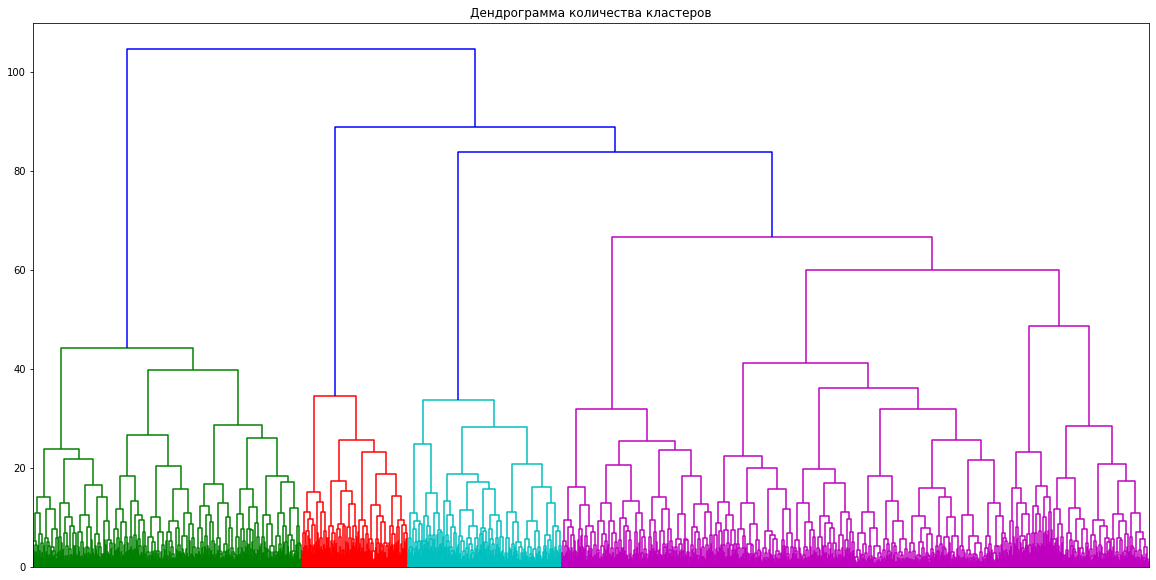

In [21]:
# построим матрицу расстояний и дендрограмму
# используем метод минимальной дисперсии Уорда и создадим таблицу "связок" между объектами
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(20, 10))  
dendrogram(linked, orientation='top')
plt.xticks([], []) 
plt.title('Дендрограмма количества кластеров')
plt.show()

- Дендрограмма выявила 4 кластера, они выделены цветами. Это говорит о том, что в кластерах признаки имеют схожие характеристики и позволяют разделить клиентов на группы.

In [22]:
# проведем кластеризацию на основе алгоритма K-Means
# зададим число кластеров 5 (для удобства проверки, хотя на дендрограмме мы видим 4 кластера)
km = KMeans(n_clusters = 5, random_state=0) 

# сформируем вектор кластеров
labels = km.fit_predict(X_sc) 

# добавим метки кластера в датасет и сгруппируем по ним данные, выведем средние значения
features = gym.copy()
features['cluster_km'] = labels
features.groupby('cluster_km').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


- Мы выделили 5 кластеров и использовали алгоритм K-Means. В таблице отражены средние значения признаков в каждом кластере.
- В кластерах необходимо уделить внимание признакам **near_location**, **partner**, **promo_friends**, **contract_period**, **group_visits**, **month_to_end_contract**, **avg_class_frequency_total**.
- Максимальные показатели у части этих признаков в cluster_0 (например, contract_period = 10.9)

In [23]:
# выделим кластеры в отдельные переменные
cluster_0 = features.query('cluster_km == 0')
cluster_1 = features.query('cluster_km == 1')
cluster_2 = features.query('cluster_km == 2')
cluster_3 = features.query('cluster_km == 3')
cluster_4 = features.query('cluster_km == 4')

In [24]:
len(cluster_0)

1011

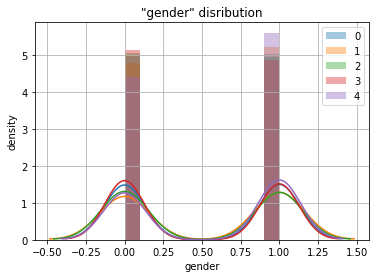

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


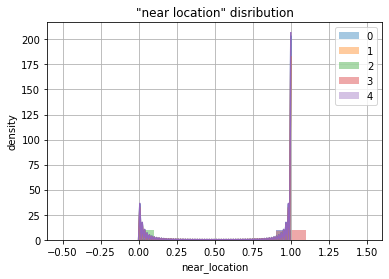

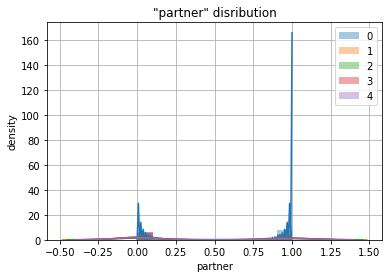

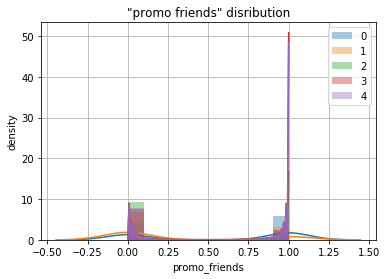

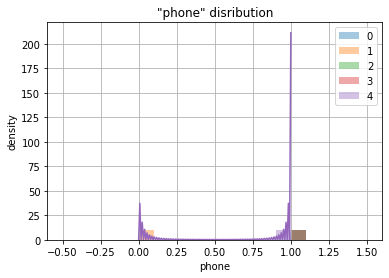

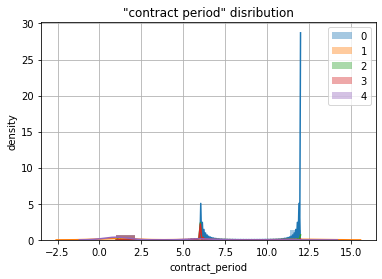

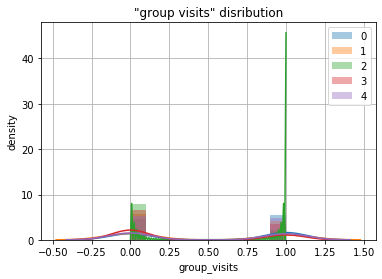

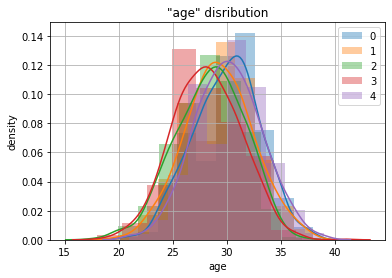

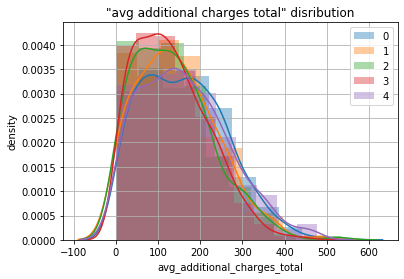

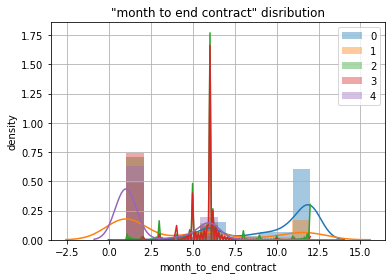

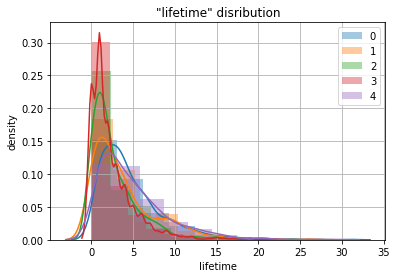

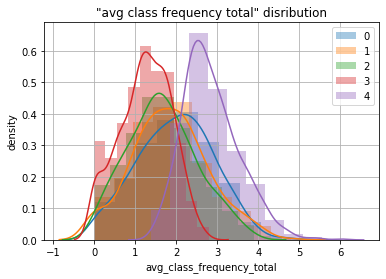

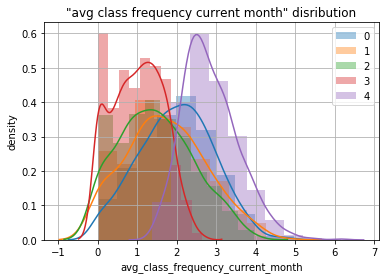

In [25]:
# построим графики распределений для кластеров
for column in features.drop(['churn', 'cluster_km'], axis=1).columns:
    sns.distplot(cluster_0[column], label='0', bins = 10)
    sns.distplot(cluster_1[column], label='1', bins = 10)
    sns.distplot(cluster_2[column], label='2', bins = 10)
    sns.distplot(cluster_3[column], label='3', bins = 10)
    sns.distplot(cluster_4[column], label='4', bins = 10)
    plt.grid(True)
    plt.ylabel('density')
    plt.title('"{}" disribution'.format(column.replace('_', ' ')))
    plt.legend()
    plt.show()

- на графиках распределения сравниваются данные 13 признаков по 5 кластерам,
- различия видны в показателях **promo_friens, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_current_month**.
- из графиков видно, что средние показатели cluster_0 часто больше, чем в остальных группах (тот же вывод сделан и на основе анализа таблицы со средними показателями).

In [26]:
features.groupby('cluster_km')['churn'].mean().to_frame().sort_values(by='churn')

,churn
cluster_km,
0,0.027695
4,0.068100
1,0.267532
2,0.443564
3,0.514263


### Вывод

- В этой части мы построили дендрограмму на основе стандартизированных данных. Дендрограмма выделила 4 кластера, но для удобства работы в дальнейшем использовано деление на 5 кластеров.
- Мы выделили 5 кластеров и использовали алгоритм K-Means:
    - В кластерах необходимо уделить внимание признакам **near_location**, **partner**, **promo_friends**, **contract_period**, **group_visits**, **month_to_end_contract**, **avg_class_frequency_total**.
    - Максимальные показатели у части этих признаков в cluster_0 (например, contract_period = 10.9)
- Мы сохранили данные по каждому кластеру в отдельный датасет и построили графики распределений:
    - на графиках распределения сравниваются данные 13 признаков по 5 кластерам,
    - различия видны в показателях **promo_friens, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_currnet**.
    - из графиков видно, что средние показатели cluster_0 часто больше, чем в остальных группах (тот же вывод сделан и на основе анализа таблицы со средними показателями).
- Самый высокий показатель оттока - у **cluster_3**, минимальный - у **cluster_0**. И между ними распределились оставшиеся три кластера. 
- Показатели, на которые следует обратить внимание в дальнейшем - это **near_location, group_visits, promo_friends, contract_period, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_current_month**.

<a id="conclusion"></a>
# 5. Общие выводы и рекомендации

**Задача проекта**: провести анализ и подготовить план действий по удержанию клиентов.

1. Датасет **`gym`** состоит из 14 столбцов и 4000 строк.
    - Данные сохранены в числовых форматах int64 float64, категориальных переменных нет.
    - Столбцы приведены к одному виду методом str.lower().


2. На втором этапе проведен исследовательский анализ данных датасета gym:
    - Проверены пропуски и дубликаты,
    - Изучены показатели среднего значения и стандартного отклонения всего датасета:
        - стандартные отклонения в большинстве случаев приближаются к среднему в исследуемом датасете;
    - При группировке данных по столбцу **churn** заметна значительная разница средних при churn=0 и churn=1 в столбцах **promo_friends, contract_period, group_visits, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_current_month**
    - Изучены столбчатые гистограммы распределения 13 признаков:
        - взяты распределения отдельных признаков без целевой переменной (всего 13 для каждого датасета)
        - если говорить не о бинарных признаках, то распределения **churn_0** и **churn_1** визуально значительно отличаются в столбцах *avg_additional_charges_total, avg_class_frequency_current_month, avg_class_frequency_total, lifetime, month_to_end_contract*,
    - Построена тепловая карта корреляций данных:
        - среди всех признаков сильно коррелируют друг с другом **month_to_end_contract** и **contract_period** (0.97), **'avg_class_frequency_current_month'** и **'avg_class_frequency_total'** (0.95).
        - сильной пложительной корреляции показателя churn с другими признаками не выявлено. Большинство корреляций - отрицательные, например, корреляция **lifetime-churn** равна -0.44.



3. Основная задача шага № 3 - оценить, как работают выбранные модели и какой процент ошибки возможен.
    - Для анализа использованы модели логистической регрессии и случайного леса.
    - Эти модели оценены с помощью метрик *доля правильных ответов (accuracy_score), точность(precision_score) и полнота (recall_score)*.
    - Для **логистической регрессии** эти показатели выглядят так:
        - Accuracy: 0.93
        - Precision: 0.86
        - Recall: 0.83
    - Для модели **случайного леса**:
        - Accuracy: 0.92
        - Precision: 0.84
        - Recall: 0.82
    - Модель **логистической регрессии** (LogisticRegression) показала более надежные результаты, т.е. при использовании этой модели процент ошибок меньше, в отличие от модели **RandomForestClassifier**.


4. В этой части мы построили дендрограмму на основе стандартизированных данных. Дендрограмма выделила 4 кластера, но для удобства работы в дальнейшем использовано деление на 5 кластеров.
    - Мы выделили 5 кластеров и использовали алгоритм K-Means:
        - В кластерах необходимо уделить внимание признакам **near_location**, **partner**, **promo_friends**, **contract_period**, **group_visits**, **month_to_end_contract**, **avg_class_frequency_total**.
        - Максимальные показатели у части этих признаков в cluster_0 (например, contract_period = 10.9)
    - Мы сохранили данные по каждому кластеру в отдельный датасет и построили графики распределений:
        - на графиках распределения сравниваются данные 13 признаков по 5 кластерам,
        - различия видны в показателях **promo_friens, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_currnet**.
        - из графиков видно, что средние показатели cluster_0 часто больше, чем в остальных группах (тот же вывод сделан и на основе анализа таблицы со средними показателями).
    - Самый высокий показатель оттока - у **cluster_3**, минимальный - у **cluster_0**. И между ними распределились оставшиеся три кластера.
  

5. Возможные сценарии.
    - Показатели, на которые следует обратить внимание в дальнейшем - это **near_location, group_visits, promo_friends, avg_additional_charges_total, month_to_end_contract, lifetime, avg_class_frequency_total, avg_class_frequency_current_month, contract_period,**, т.е. проживание или работа в районе, где находится фитнес-центр, посещение групповых занятий, акция "приведи друга", суммарная выручка от других услуг, срок до окончания текущего действующего абонемента (в месяцах), время с момента первого обращения в фитнес-центр, средняя частота посещений в неделю за все время с начала действия абонемента и за предыдущий месяц, длительность текущего абонемента.
    - Уделить внимение развитию партнерских программ с организациями, расположенными рядом с фитнес-центрами (здесь задействованы "работа в районе, где находится фитнес-центр" и "сотрудник компании-партнёра клуба", а также "посещение групповых занятий"), развивать местное комьюнити (жители ближайших районов),
    - Разработать программу лояльности: например, традиционные специальные предложения, карты, мерч, основанные на индивидуальных предпочтениях (здесь может помочь кластеризация, а также дополнительное анкетирование),
    - Предложить дополнительные бонусы/скидки/др. при покупке абонемента на полгода и год (еще один стандартный метод),
    - Также, например, ввести дополнительные занятия и форматы (исходя из потребностей клиентов): онлайн-занятия, "утренняя тренировка+кофе", подготовка к забегу/триатлону/другому соревнованию. Здесь идет работа с кластерами, дополнительным опросом при необходимости. Такой подход поможет компании проявить свою гибкость и покажет ее стремление искать нестандартные решения. 